In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['font.family'] = 'monospace'
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, 
    Bidirectional, LSTM, Dropout, Dense,
)


In [50]:
WORKSPACE = os.path.abspath(os.path.join(os.getcwd()))
DATA_FOLDER = os.path.join(WORKSPACE, 'productos/test/precipitation-forecast-co/data')
MODELS_FOLDER = os.path.join(WORKSPACE, 'productos/test/precipitation-forecast-co/models')

In [51]:
processing_data = os.path.join(DATA_FOLDER, 'processing/processing_month.parquet')
df = pd.read_parquet(processing_data)

# Expand IMFs and VMDs
imf_n=df['IMFs'].str.len().max()
imf_c=[f'imf{i+1}' for i in range(imf_n)]
vmd_n=df['VMDs'].str.len().max()
vmd_c=[f'vmd{i+1}' for i in range(vmd_n)]
df=pd.concat([df,pd.DataFrame(df['IMFs'].tolist(),columns=imf_c),pd.DataFrame(df['VMDs'].tolist(),columns=vmd_c)],axis=1)
df.drop(columns=['IMFs','VMDs'],inplace=True)

def compute_sample_weights(y_data):
    """
    Compute sample weights based on deviation from mean.
    Samples farther from mean get higher weights.
    """
    mean_value = np.mean(y_data)
    # Calculate absolute deviation from mean
    deviations = np.abs(y_data - mean_value)
    # Normalize to get weights in a reasonable range (0.5 to 2.0)
    # Add small epsilon to avoid division by zero
    max_dev = np.max(deviations) + 1e-10
    # Scale deviations to range [0, 1] and then to range [0.5, 2.0]
    weights = 0.5 + 1.5 * (deviations / max_dev)
    return weights

In [52]:
def split_data(df, context_length, feature):
    """
    Prepares training and testing data from a column of normalized arrays.
    """
    X_train, X_test, y_train, y_test = [], [], [], []

    for window in df[feature]:
        if window is None:
            continue
        X, y = [], []
        for i in range(len(window) - context_length):
            X.append(window[i:i+context_length])
            y.append(window[i+context_length])
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        split_idx = int(len(X) * 0.8)
        X_train.append(X[:split_idx])
        X_test.append(X[split_idx:])
        y_train.append(y[:split_idx])
        y_test.append(y[split_idx:])

    X_train = np.concatenate(X_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    X_train = X_train.reshape(-1, context_length, 1)
    X_test = X_test.reshape(-1, context_length, 1)

    return X_train, X_test, y_train, y_test

## XGBoost

In [56]:
context_length = 32
features = ['ValoresNormalizados']
    
def custom_loss_xgb(y_pred, dtrain, alpha=0.6, beta=0.2, gamma=0.2):
    y_true = dtrain.get_label()
    error = y_pred - y_true

    # --- Huber loss ---
    delta = 1.5
    abs_error = np.abs(error)
    is_small_error = abs_error <= delta

    # Gradiente Huber
    grad_huber = np.where(is_small_error, error, delta * np.sign(error))
    # Hessiano Huber
    hess_huber = np.where(is_small_error, 1.0, 0.0)

    # --- Componente alta precipitación (>0.6) ---
    high_mask = (y_true > 0.6).astype(float)
    grad_high = 2 * high_mask * error
    hess_high = 2 * high_mask

    # --- Componente baja precipitación (<0.1) ---
    low_mask = (y_true < 0.1).astype(float)
    grad_low = 2 * low_mask * error
    hess_low = 2 * low_mask

    # --- Combinación ponderada ---
    grad_total = alpha * grad_huber + beta * grad_high + gamma * grad_low
    hess_total = alpha * hess_huber + beta * hess_high + gamma * hess_low

    return grad_total, hess_total

for feature_column in features:
    # Preparar los datos
    X_train, X_test, y_train, y_test = split_data(df, context_length=context_length, feature=feature_column)
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")

    sample_weights = compute_sample_weights(y_train.flatten())
    dtrain = xgb.DMatrix(X_train, label=y_train, 
                         weight=sample_weights
                         )
    dtest = xgb.DMatrix(X_test, label=y_test)

    params = {
        'max_depth': 8,
        'eta': 0.03,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'eval_metric': 'rmse'
    }

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        obj=custom_loss_xgb,
        evals=[(dtest, "test")],
        early_stopping_rounds=100,
        verbose_eval=True
    )

    # Evaluar el modelo
    pred = model.predict(dtest)
    loss = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    print(f"Val loss={loss:.5f}, Val MAE={mae:.5f}")

    # Guardar el modelo
    os.makedirs(MODELS_FOLDER, exist_ok=True)
    model.save_model(os.path.join(MODELS_FOLDER, f"xgb_{feature_column}.json"))

Forma de X_train: (209570, 32), y_train: (209570, 1)
Forma de X_test: (54055, 32), y_test: (54055, 1)
[0]	test-rmse:0.27902
[1]	test-rmse:0.27351
[2]	test-rmse:0.26821
[3]	test-rmse:0.26307
[4]	test-rmse:0.25812
[5]	test-rmse:0.25340
[6]	test-rmse:0.24898
[7]	test-rmse:0.24463
[8]	test-rmse:0.24048
[9]	test-rmse:0.23647
[10]	test-rmse:0.23266
[11]	test-rmse:0.22898
[12]	test-rmse:0.22554
[13]	test-rmse:0.22217
[14]	test-rmse:0.21896
[15]	test-rmse:0.21595
[16]	test-rmse:0.21306
[17]	test-rmse:0.21029
[18]	test-rmse:0.20760
[19]	test-rmse:0.20503
[20]	test-rmse:0.20263
[21]	test-rmse:0.20032
[22]	test-rmse:0.19808
[23]	test-rmse:0.19604
[24]	test-rmse:0.19402
[25]	test-rmse:0.19208
[26]	test-rmse:0.19029
[27]	test-rmse:0.18855
[28]	test-rmse:0.18688
[29]	test-rmse:0.18528
[30]	test-rmse:0.18377
[31]	test-rmse:0.18236
[32]	test-rmse:0.18102
[33]	test-rmse:0.17972
[34]	test-rmse:0.17845
[35]	test-rmse:0.17728
[36]	test-rmse:0.17620
[37]	test-rmse:0.17514
[38]	test-rmse:0.17413
[39]	test-r

## LSTM

Entrenando modo: ValoresNormalizados
Forma de X_train: (209570, 32, 1), y_train: (209570, 1)
Forma de X_test: (54055, 32, 1), y_test: (54055, 1)
Epoch 1/200


I0000 00:00:1750451819.439438   56134 cuda_dnn.cc:529] Loaded cuDNN version 90300


205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0744 - mae: 0.1639 - val_loss: 0.0252 - val_mae: 0.1580 - learning_rate: 0.0010
Epoch 2/200
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0150 - mae: 0.1248 - val_loss: 0.0208 - val_mae: 0.1836 - learning_rate: 0.0010
Epoch 3/200
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0102 - mae: 0.1210 - val_loss: 0.0114 - val_mae: 0.1201 - learning_rate: 0.0010
Epoch 4/200
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0093 - mae: 0.1199 - val_loss: 0.0110 - val_mae: 0.1207 - learning_rate: 0.0010
Epoch 5/200
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0090 - mae: 0.1196 - val_loss: 0.0107 - val_mae: 0.1216 - learning_rate: 0.0010
Epoch 6/200
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0089 - mae: 0.1193 - val_loss: 0.0107 - val_mae: 0.1250 - learning_rate: 0.0010
Epoch 7/200
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0088 - mae: 0.1191 - val_loss: 0.0107 - val_mae: 0.1211 - learning_rate: 0.0010
Epoc

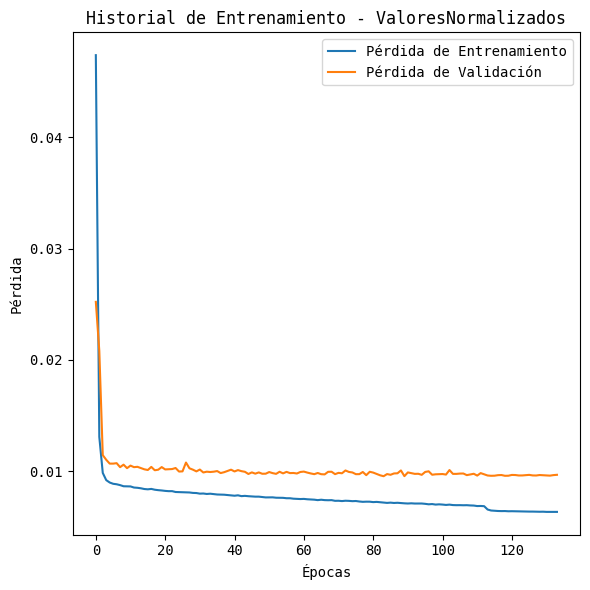

In [ ]:
context_length = 32
df_pred = pd.DataFrame()
features = ['ValoresNormalizados']

for feature_column in features:
    print(f"Entrenando modo: {feature_column}")

    # Preparar los datos
    X_train, X_test, y_train, y_test = split_data(df, context_length=32, feature=feature_column)
    print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")

    sample_weights = compute_sample_weights(y_train.flatten())

    # Construir el modelo LSTM - biLSTM
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters=64, kernel_size=5, padding='causal', activation='relu'),
        Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu'),
        BatchNormalization(),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005)),
        #Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005))),
        Dropout(0.1),
        LSTM(32, return_sequences=False, kernel_regularizer=l2(0.0005)),
        #Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.0005))),                                                                                                          
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.0005)),
        Dense(16, activation='relu', kernel_regularizer=l2(0.0005)),
        Dense(1)
    ])

    def custom_loss(y_true, y_pred, alpha=0.6, beta=0.2, gamma=0.2):
        """
        Loss personalizado para datos de precipitación que combina:
        - Huber loss para robustez general
        - Mayor peso a predicciones de lluvia alta (>0.6) - eventos importantes
        - Mayor peso a predicciones de sequía (<0.1) - períodos secos críticos
        """
        huber = tf.keras.losses.Huber(delta=1.5)(y_true, y_pred)
        
        # Peso extra para valores altos de precipitación (lluvia intensa)
        high_precip_mask = tf.cast(y_true > 0.6, tf.float32)
        high_weighted_component = tf.reduce_mean(high_precip_mask * tf.square(y_true - y_pred))
        
        # Peso extra para valores bajos de precipitación (sequía)
        low_precip_mask = tf.cast(y_true < 0.1, tf.float32)
        low_weighted_component = tf.reduce_mean(low_precip_mask * tf.square(y_true - y_pred))
        
        # Combinación balanceada: alpha*huber + beta*alta_lluvia + gamma*sequía
        return alpha * huber + beta * high_weighted_component + gamma * low_weighted_component

    model.compile(optimizer=Adam(learning_rate=0.001), 
                loss=custom_loss,
                metrics=['mae'])

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=30,
        min_lr=1e-6
    )

    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=1024,
        validation_data=(X_test, y_test),
        sample_weight=sample_weights,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluar el modelo
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Val loss={loss:.5f}, Val MAE={mae:.5f}")

    # Graficar historial de entrenamiento
    plt.figure(figsize=(6, 6))
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title(f'Historial de Entrenamiento - {feature_column}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.tight_layout()
    os.makedirs(os.path.join(DATA_FOLDER, "img/models"), exist_ok=True)
    plt.savefig(os.path.join(DATA_FOLDER, f"img/models/mlstm_{feature_column}.png"), dpi=300)
    #plt.savefig(os.path.join(DATA_FOLDER, f"img/models/mbilstm_{feature_column}.png"), dpi=300)

    # Guardar el modelo 
    os.makedirs(MODELS_FOLDER, exist_ok=True)
    model.save(os.path.join(MODELS_FOLDER, f"mlstm_{feature_column}.keras"))
    #model.save(os.path.join(MODELS_FOLDER, f"mbilstm_{feature_column}.keras"))


## CEEMDAN VMD - biLSTM

In [ ]:
context_length = 32
df_pred = pd.DataFrame()
features = imf_c+vmd_c
features = [f for f in features if f != 'imf1']

for feature_column in features:
    print(f"Entrenando modo: {feature_column}")

    # Preparar los datos
    X_train, X_test, y_train, y_test = split_data(df, context_length=32, feature=feature_column)
    print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Construir el modelo LSTM
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005))),
        Dropout(0.1),
        Bidirectional(LSTM(32, return_sequences=False,kernel_regularizer=l2(0.0005))),
        Dropout(0.3),
        Dense(16, activation='swish', kernel_regularizer=l2(0.0005)),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mse',
                  metrics=['mae'])

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=20,
        min_lr=1e-6
    )

    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=1028,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluar el modelo
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Val loss={loss:.5f}, Val MAE={mae:.5f}")

    # Graficar historial de entrenamiento
    plt.figure(figsize=(6, 6))
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title(f'Historial de Entrenamiento - {feature_column}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.tight_layout()
    os.makedirs(os.path.join(DATA_FOLDER, "img/models"), exist_ok=True)
    plt.savefig(os.path.join(DATA_FOLDER, f"img/models/mbilstm_{feature_column}.png"), dpi=300)

    # Guardar el modelo 
    os.makedirs(MODELS_FOLDER, exist_ok=True)
    model.save(os.path.join(MODELS_FOLDER, f"mbilstm_{feature_column}.keras"))

Entrenando modo: imf2
Forma de X_train: (209570, 32, 1), y_train: (209570, 1)
Forma de X_test: (54055, 32, 1), y_test: (54055, 1)
Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 26s 114ms/step - loss: 0.0824 - mae: 0.0850 - val_loss: 0.0094 - val_mae: 0.0630 - learning_rate: 0.0010
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - loss: 0.0076 - mae: 0.0591 - val_loss: 0.0058 - val_mae: 0.0545 - learning_rate: 0.0010
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - loss: 0.0057 - mae: 0.0546 - val_loss: 0.0051 - val_mae: 0.0511 - learning_rate: 0.0010
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - loss: 0.0051 - mae: 0.0521 - val_loss: 0.0046 - val_mae: 0.0490 - learning_rate: 0.0010
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - loss: 0.0048 - mae: 0.0507 - val_loss: 0.0043 - val_mae: 0.0472 - learning_rate: 0.0010
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - loss: 0.0045 - mae: 0.0490 - val_loss: 0.0042 - val_mae: 0.0465 - learning_rate: 0

## SVM - biLSTM

In [48]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === Paths ===
WORKSPACE = os.path.abspath(os.getcwd())
DATA_FOLDER = os.path.join(WORKSPACE, 'productos/test/precipitation-forecast-co/data')
MODELS_FOLDER = os.path.join(WORKSPACE, 'productos/test/precipitation-forecast-co/models')
IMG_FOLDER = os.path.join(DATA_FOLDER, 'img', 'models')
os.makedirs(IMG_FOLDER, exist_ok=True)
os.makedirs(MODELS_FOLDER, exist_ok=True)

np.random.seed(42)
tf.random.set_seed(42)

def custom_loss(y_true, y_pred, a=0.6, b=0.2, g=0.2):
    h = tf.keras.losses.Huber(1.5)(y_true, y_pred)
    hi = tf.reduce_mean(tf.cast(y_true > .6, tf.float32) * tf.square(y_true - y_pred))
    lo = tf.reduce_mean(tf.cast(y_true < .1, tf.float32) * tf.square(y_true - y_pred))
    return a*h + b*hi + g*lo

def distributed_sample(y_data, num_samples=None):
    y_data = y_data.flatten()
    bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.01]
    indices = []
    per_bin = None
    total_len = len(y_data)
    if num_samples is not None:
        per_bin = max(1, num_samples // 5)
    for i in range(5):
        bin_mask = (y_data >= bins[i]) & (y_data < bins[i+1])
        bin_idx = np.where(bin_mask)[0]
        if len(bin_idx) == 0:
            continue
        take = int(0.2 * total_len) if per_bin is None else min(per_bin, len(bin_idx))
        chosen = np.random.choice(bin_idx, size=take, replace=len(bin_idx)<take)
        indices.append(chosen)
    return np.concatenate(indices)

class SVM_Discriminator:
    def __init__(self, kernel='rbf', probability=True):
        self.svm = SVC(kernel=kernel, probability=True)
        self.scaler = StandardScaler()
    def fit(self, real_data, noise_data):
        X = np.vstack([real_data.reshape(len(real_data), -1), noise_data.reshape(len(noise_data), -1)])
        self.scaler.fit(X)
        X_scaled = self.scaler.transform(X)
        y = np.concatenate([np.ones(len(real_data)), np.zeros(len(noise_data))])
        self.svm.fit(X_scaled, y)
        return self
    def predict_proba(self, data):
        data_reshaped = data.reshape(len(data), -1)
        data_scaled = self.scaler.transform(data_reshaped)
        return self.svm.predict_proba(data_scaled)[:, 1]

def build_lstm_model(input_shape):
    return Sequential([
        Input(shape=input_shape),
        Conv1D(64, 5, padding='causal', activation='relu'),
        Conv1D(32, 3, padding='causal', activation='relu'),
        BatchNormalization(),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(5e-4)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(5e-4)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(5e-4)),
        Dense(16, activation='relu', kernel_regularizer=l2(5e-4)),
        Dense(1)
    ])

class SBiLSTM_Model:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.lstm = build_lstm_model(input_shape)
        self.discriminator = SVM_Discriminator()
        self.initial_lr = 0.001
        self.optimizer = Adam(learning_rate=self.initial_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
        self.best_loss = float('inf')
        self.monitor_active = False
        self.monitor_count = 0
        self.monitor_start_loss = 0
        self.cooldown_counter = 0
        self.monitor_period = 3
        self.cooldown_period = 3

    def _compute_sample_weights(self, y_data):
        mean_value = np.mean(y_data)
        deviations = np.abs(y_data - mean_value)
        max_dev = np.max(deviations) + 1e-10
        weights = 0.5 + 2.5 * (deviations / max_dev)
        return weights

    def _adjust_learning_rate(self, current_loss, epoch):
        current_lr = self.optimizer.learning_rate.numpy()
        if self.cooldown_counter > 0:
            self.cooldown_counter -= 1
            return
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            if self.monitor_active:
                self.monitor_active = False
        elif current_loss > self.best_loss:
            if current_loss > 2 * self.best_loss:
                print(f"\nEpoch {epoch+1}: Error rebounded more than 2x. Resetting LR to 0.001")
                self.optimizer.learning_rate.assign(0.001)
                self.monitor_active = False
                self.best_loss = current_loss
                return
            if not self.monitor_active:
                self.monitor_active = True
                self.monitor_count = 0
                self.monitor_start_loss = current_loss
                print(f"\nEpoch {epoch+1}: Error increased. Starting monitoring for {self.monitor_period} epochs.")
            else:
                self.monitor_count += 1
                if self.monitor_count >= self.monitor_period:
                    if current_loss >= self.monitor_start_loss:
                        new_lr = current_lr * 0.9
                        self.optimizer.learning_rate.assign(new_lr)
                        print(f"\nEpoch {epoch+1}: After {self.monitor_period} epochs of monitoring, error not decreasing.")
                        print(f"Reducing learning rate from {current_lr:.6f} to {new_lr:.6f}")
                    self.monitor_active = False
                    self.cooldown_counter = self.cooldown_period

    def train(self, X_train, y_train, noise_data, epochs=100, batch_size=1024, validation_data=None, save_path=None):
        history = {'loss': [], 'mse_loss': [], 'svm_loss': [], 'svm_accuracy': [], 'learning_rate': []}
        if validation_data is not None:
            history['val_loss'] = []
            X_val, y_val = validation_data
        sample_weights = self._compute_sample_weights(y_train)
        max_samples = 10000
        n_samples = min(len(y_train), max_samples)
        idx = distributed_sample(y_train, num_samples=n_samples)
        noise_data_sample = noise_data[idx]
        y_train_sample = y_train[idx]
        self.discriminator.fit(y_train_sample, noise_data_sample)
        best_val_loss = float('inf')
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_mse = 0
            epoch_svm = 0
            indices = np.random.permutation(len(X_train))
            for i in range(0, len(X_train), batch_size):
                batch_indices = indices[i:min(i+batch_size, len(X_train))]
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices]
                weights_batch = sample_weights[batch_indices]
                with tf.GradientTape() as tape:
                    predictions = self.lstm(X_batch, training=True)
                    mse_loss = custom_loss(tf.convert_to_tensor(y_batch, dtype=tf.float32), predictions)
                    svm_probs = self.discriminator.predict_proba(predictions.numpy())
                    svm_probs = tf.convert_to_tensor(svm_probs, dtype=tf.float32)
                    svm_loss = -tf.reduce_mean(tf.math.log(svm_probs + 1e-10))
                    total_loss = mse_loss + svm_loss
                gradients = tape.gradient(total_loss, self.lstm.trainable_variables)
                self.optimizer.apply_gradients(zip(gradients, self.lstm.trainable_variables))
                epoch_loss += total_loss.numpy()
                epoch_mse += mse_loss.numpy()
                epoch_svm += svm_loss.numpy()
            num_batches = np.ceil(len(X_train) / batch_size)
            epoch_loss /= num_batches
            epoch_mse /= num_batches
            epoch_svm /= num_batches
            self._adjust_learning_rate(epoch_loss, epoch)
            current_lr = self.optimizer.learning_rate.numpy()
            train_preds = self.lstm.predict(X_train, verbose=0)
            svm_scores = self.discriminator.predict_proba(train_preds)
            svm_accuracy = np.mean(svm_scores > 0.5)
            history['loss'].append(epoch_loss)
            history['mse_loss'].append(epoch_mse)
            history['svm_loss'].append(epoch_svm)
            history['svm_accuracy'].append(svm_accuracy)
            history['learning_rate'].append(current_lr)
            if validation_data is not None:
                val_preds = self.lstm.predict(X_val, verbose=0)
                val_weights = self._compute_sample_weights(y_val)
                val_mse = np.mean((val_preds.flatten() - y_val.flatten()) ** 2 * val_weights.flatten())
                history['val_loss'].append(val_mse)
                if save_path and val_mse < best_val_loss and 0.1 <= svm_accuracy <= 0.3:
                    best_val_loss = val_mse
                    self.lstm.save(save_path)
                    print(f"Epoch {epoch+1}: New best model saved with val_loss: {val_mse:.4f} and svm_acc: {svm_accuracy:.4f}")
            if epoch % 5 == 0:
                train_preds = self.lstm.predict(X_train, verbose=0)
                real_data = y_train
                fake_data = train_preds
                n_samples = min(len(real_data), len(fake_data), max_samples)
                idx = distributed_sample(real_data, num_samples=n_samples)
                real_data_sample = real_data[idx]
                fake_data_sample = fake_data[idx]
                self.discriminator.fit(real_data_sample, fake_data_sample)
            if epoch % 10 == 0 or epoch == epochs - 1:
                log_msg = f"Epoch {epoch+1}/{epochs} - loss: {epoch_loss:.4f} - mse: {epoch_mse:.4f} - svm_loss: {epoch_svm:.4f} - svm_acc: {svm_accuracy:.4f} - lr: {current_lr:.6f}"
                if validation_data is not None:
                    log_msg += f" - val_loss: {history['val_loss'][-1]:.4f}"
                print(log_msg)
        if save_path and validation_data is None:
            self.lstm.save(save_path)
            print(f"Final model saved to {save_path}")
        return history

    def predict(self, X):
        return self.lstm.predict(X, verbose=0)

def apply_sbilstm_methodology(df, lag_steps=32):
    assert all(isinstance(x, np.ndarray) for x in df['ValoresNormalizados'])
    X_train, X_test, y_train, y_test = [], [], [], []
    for window in df['ValoresNormalizados']:
        X, y = [], []
        for i in range(len(window) - lag_steps):
            X.append(window[i:i+lag_steps])
            y.append(window[i+lag_steps])
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        split_idx = int(len(X) * 0.8)
        X_train.append(X[:split_idx])
        X_test.append(X[split_idx:])
        y_train.append(y[:split_idx])
        y_test.append(y[split_idx:])
    X_train = np.concatenate(X_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    y_test = np.concatenate(y_test, axis=0)
    X_train = X_train.reshape(-1, lag_steps, 1)
    X_test = X_test.reshape(-1, lag_steps, 1)
    print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")
    y_train = y_train.astype(np.float32)
    mean = np.mean(y_train)
    std = np.std(y_train) or 0.05
    noise_data = np.clip(np.random.normal(mean, std * 0.1, y_train.shape), 0, 1)
    model_path = os.path.join(MODELS_FOLDER, 'msbilstm_ValoresNormalizados.keras')
    model = SBiLSTM_Model((lag_steps, 1))
    history = model.train(X_train, y_train, noise_data=noise_data, epochs=100, batch_size=1024, validation_data=(X_test, y_test), save_path=model_path)
    predictions = model.predict(X_test)
    mse = np.mean((predictions.flatten() - y_test.flatten()) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions.flatten() - y_test.flatten()))
    print(f"\nTest Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history['mse_loss'], label='MSE Loss')
    plt.plot(history['svm_loss'], label='SVM Loss')
    plt.plot(history['loss'], label='Total Loss')
    if 'val_loss' in history and history['val_loss']:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(IMG_FOLDER, 'msbilstm_ValoresNormalizados.png'))
    plt.close()
    return model, history, predictions

if __name__ == "__main__":
    processing_data = os.path.join(DATA_FOLDER, 'processing/processing_month.parquet')
    df = pd.read_parquet(processing_data)
    model, history, predictions = apply_sbilstm_methodology(df, lag_steps=32)

Forma de X_train: (209570, 32, 1), y_train: (209570, 1)
Forma de X_test: (54055, 32, 1), y_test: (54055, 1)
Epoch 1/100 - loss: 0.6606 - mse: 0.0148 - svm_loss: 0.6458 - svm_acc: 0.6635 - lr: 0.001000 - val_loss: 0.0751

Epoch 5: Error increased. Starting monitoring for 3 epochs.

Epoch 7: Error rebounded more than 2x. Resetting LR to 0.001
Epoch 11/100 - loss: 0.9718 - mse: 0.0089 - svm_loss: 0.9629 - svm_acc: 0.0684 - lr: 0.001000 - val_loss: 0.0433

Epoch 12: Error increased. Starting monitoring for 3 epochs.
Epoch 17: New best model saved with val_loss: 0.0380 and svm_acc: 0.1143
Epoch 18: New best model saved with val_loss: 0.0378 and svm_acc: 0.1267

Epoch 20: Error increased. Starting monitoring for 3 epochs.
Epoch 21: New best model saved with val_loss: 0.0374 and svm_acc: 0.1230
Epoch 21/100 - loss: 0.9521 - mse: 0.0083 - svm_loss: 0.9438 - svm_acc: 0.1230 - lr: 0.001000 - val_loss: 0.0374
Epoch 31/100 - loss: 0.9304 - mse: 0.0079 - svm_loss: 0.9226 - svm_acc: 0.0757 - lr: 0.0